# Project: Engagement prediction of news articles on Facebook

**42578 Advanced Business Analytics**

DTU, 1st of April 2022

_Name and study ID_: 

| Name | Study ID |
| --- | --- |
| Benjamin | s184314|
| Cecilie | s184304|
| Ellen | s184313|
| Jens | s183568 | 
| Julius | s184288 | 

## Description of chosen dataset
This dataset *Internet news data with readers engagement* is downloaded from Kaggle (link: https://www.kaggle.com/szymonjanowski/internet-articles-data-with-users-engagement). The dataset contains basic information about news articles: publisher, author, title and a short description together with engagement signals on Facebook (e.g. number of likes). Besides that, each article is provided with an URL to both the news article and associated photo, so it is possible to scrape extra information.   

The dataset consists of 10.437 rows and 14 columns. The data was collected between 03.09.2019 and 03.10.2019 (DD.MM.YYYY). 


## Research questions

This project will focus on how the engagement of new articles is impacted by the contents of the article such as the title, description and the image. To carry out the analysis several research questions have been created:

* Which attributes contribute most to the engagement?

* What metric best describes the value of engagement based on the given counts of shares, comments and reactions?

* What similarities can be found between the articles with a high engagement count?

* How can a supervised LDA model be used to predict engagement based on topics?

* Can the prediction be improved by using neural networks for modeling both the article content and image?


## Descriptive Stats

To begin with some descriptive statistics is carried out in order to understand and process the data for the following analysis. 

**Loading packages**

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot
import matplotlib.dates
from datetime import datetime
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns
from sklearn.feature_extraction import _stop_words
import string
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, sent_tokenize
lemmatizer = WordNetLemmatizer()
Stop_Words= _stop_words.ENGLISH_STOP_WORDS
import textblob
from wordcloud import WordCloud,STOPWORDS
import re
import gensim
from gensim.models.ldamodel import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models
from gensim import corpora, models
plt.rcParams["figure.figsize"] = (20,5)

In [133]:
df = pd.read_csv('articles_data.csv', index_col = 0)
df.head(5)

,source_id,source_name,author,title,description,url,url_to_image,published_at,content,top_article,engagement_reaction_count,engagement_comment_count,engagement_share_count,engagement_comment_plugin_count
0,reuters,Reuters,Reuters Editorial,NTSB says Autopilot engaged in 2018 California...,The National Transportation Safety Board said ...,https://www.reuters.com/article/us-tesla-crash...,https://s4.reutersmedia.net/resources/r/?m=02&...,2019-09-03T16:22:20Z,WASHINGTON (Reuters) - The National Transporta...,0.0,0.0,0.0,2528.0,0.0
1,the-irish-times,The Irish Times,Eoin Burke-Kennedy,Unemployment falls to post-crash low of 5.2%,Latest monthly figures reflect continued growt...,https://www.irishtimes.com/business/economy/un...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T10:32:28Z,The States jobless rate fell to 5.2 per cent l...,0.0,6.0,10.0,2.0,0.0
2,the-irish-times,The Irish Times,Deirdre McQuillan,"Louise Kennedy AW2019: Long coats, sparkling t...",Autumn-winter collection features designer’s g...,https://www.irishtimes.com/\t\t\t\t\t\t\t/life...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T14:40:00Z,Louise Kennedy is showing off her autumn-winte...,1.0,NaN,NaN,NaN,NaN
3,al-jazeera-english,Al Jazeera English,Al Jazeera,North Korean footballer Han joins Italian gian...,Han is the first North Korean player in the Se...,https://www.aljazeera.com/news/2019/09/north-k...,https://www.aljazeera.com/mritems/Images/2019/...,2019-09-03T17:25:39Z,"Han Kwang Song, the first North Korean footbal...",0.0,0.0,0.0,7.0,0.0
4,bbc-news,BBC News,BBC News,UK government lawyer says proroguing parliamen...,"The UK government's lawyer, David Johnston arg...",https://www.bbc.co.uk/news/av/uk-scotland-4956...,https://ichef.bbci.co.uk/news/1024/branded_new...,2019-09-03T14:39:21Z,NaN,0.0,0.0,0.0,0.0,0.0


In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10437 entries, 0 to 10436
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   source_id                        10437 non-null  object 
 1   source_name                      10437 non-null  object 
 2   author                           9417 non-null   object 
 3   title                            10435 non-null  object 
 4   description                      10413 non-null  object 
 5   url                              10436 non-null  object 
 6   url_to_image                     9781 non-null   object 
 7   published_at                     10436 non-null  object 
 8   content                          9145 non-null   object 
 9   top_article                      10435 non-null  float64
 10  engagement_reaction_count        10319 non-null  float64
 11  engagement_comment_count         10319 non-null  float64
 12  engagement_share_c

In [111]:
print("The 'description' column has:", df.description.isna().sum(), "missing values")
print("The 'url_to_image' column has:", df.url_to_image.isna().sum(), "missing values")
engagement_missing = df[['engagement_reaction_count', 'engagement_comment_count', 'engagement_share_count']].isna().sum()[0]
print("The 'engagement' columns has:", engagement_missing, "missing values")

The 'description' column has: 24 missing values
The 'url_to_image' column has: 656 missing values
The 'engagement' columns has: 118 missing values


We can see that the column `description` has 24 missing values. 

**Creating a new date column with yyyy-mm-dd** 

From the info of the dataset it can be seen that the `publised_at` attribute is defined as an object. This attribute is a date, thus it has to be transformed to date type. 

In [134]:
df['Date']= pd.to_datetime(df['published_at'])#.dt.date #remove the '.dt.date' if you want to keep the time of the day

In [113]:
# We can now look at what the timeframe of the data is
print("The earliest date is:", df["Date"].min())
print("The latest date is:", df["Date"].max())

The earliest date is: 2019-09-03 00:00:00+00:00
The latest date is: 2019-10-03 17:49:31+00:00


There is row with missing date. We take a look at this row: 

In [114]:
df[df.Date.isnull()]

,source_id,source_name,author,title,description,url,url_to_image,published_at,content,top_article,engagement_reaction_count,engagement_comment_count,engagement_share_count,engagement_comment_plugin_count,Date
750,1,460.0,151.0,352.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [115]:
# This function is from the following website: https://www.kaggle.com/code/thomaskonstantin/exploring-and-modeling-internet-news-data/notebook

fig = make_subplots(rows=3, cols=1, subplot_titles=('Engagement Reaction Count','Engagement Comment Count','Engagement Share Count'))

b_date_mean = df.copy()
b_date_mean.published_at = pd.to_datetime(b_date_mean.published_at).dt.normalize()
b_date_mean = b_date_mean.groupby(by='published_at').mean().reset_index()

fig.add_trace(
go.Scatter(x=b_date_mean.published_at, y=b_date_mean.engagement_reaction_count,name='engagement_reaction_count'),
row=1, col=1)

fig.add_trace(
go.Scatter(x=b_date_mean.published_at, y=b_date_mean.engagement_comment_count,name='engagement_comment_count'),
row=2, col=1)

fig.add_trace(
go.Scatter(x=b_date_mean.published_at, y=b_date_mean.engagement_share_count,name='engagement_share_count'),
row=3, col=1)

fig.update_layout(height=600, width=900, title_text="Behavior Of Different Engagement Attributes Over Time")
fig.show()

In [135]:
#function to do rough cleaning of data

def text_preprocessing(text):
    text = "".join([c.lower() for c in text]) # lowercase
    return text

def clean_text(text):
    # lowercase
    text = "".join([c.lower() for c in text])
    
    #remove hyperlink
    text = re.sub('https?://\S+|www\.\S+', '', text) 
    
    # remove punctuation and special characters
    text = re.sub(r"[^a-zA-Z0-9]+", ' ', text)

    # remove stopwords
    text = " ".join([w for w in text.split() 
                     if w not in Stop_Words])
    # lematizing
    text = " ".join([lemmatizer.lemmatize(w) for w in text.split()])
    
    # remove numbers
    text = "".join([i for i in text if not i.isdigit()])
    
    #remove words of 1 letter length
    text= " ".join([word for word in text.split() if len(word) >= 2])
    
    return text

def drop_na(df):
    df = df.dropna(axis = 0)
    df = df[~(df['description'] == 'nan')]
    return df


def preprocessing(df):
    #delete rows from source 460.0
    df = df.drop(df[df.source_name == "460.0"].index)
    #make descriptions lower case
    df['description'] = df['description'].astype(str).apply(text_preprocessing)
    df['cleaned_description'] = df['description'].astype(str).apply(clean_text)
    df['title'] = df['title'].astype(str).apply(text_preprocessing)
    df['cleaned_title'] = df['title'].astype(str).apply(clean_text)
    
    #day of week
    df['Day_Of_Week'] = df.Date.apply(lambda x: x.dayofweek)
    
    #select attributes of interest
    df = df[['Date', 'title', 'cleaned_title', 'description', 'url_to_image', 'engagement_reaction_count', 
             'engagement_comment_count', 'engagement_share_count', 'Day_Of_Week', 'cleaned_description', 
             'top_article', 'source_name']]
    
    #drop nan's
    df = drop_na(df)
    
    #calculate engagement total 
    df['engagement'] = df['engagement_reaction_count'] + df['engagement_comment_count'] +df['engagement_share_count']
    #calculate engagement in log domain
    df['engagement_log'] = np.log(df['engagement'] + 0.0001)
    
    df = df[['source_name', 'title', 'cleaned_title','description','cleaned_description', 'url_to_image', 
             'top_article', 'engagement', 'engagement_log', 'Day_Of_Week']].copy()
    df = df.reset_index(drop=True)
    return df

<>:12: DeprecationWarning:

invalid escape sequence \S

<>:12: DeprecationWarning:

invalid escape sequence \S

<>:12: DeprecationWarning:

invalid escape sequence \S

/var/folders/bt/qsvsbmhj5vsfqv2mng432_yw0000gn/T/ipykernel_45780/1891601646.py:12: DeprecationWarning:

invalid escape sequence \S



In [136]:
df = preprocessing(df)
df.head()

,source_name,title,cleaned_title,description,cleaned_description,url_to_image,top_article,engagement,engagement_log,Day_Of_Week
0,Reuters,ntsb says autopilot engaged in 2018 california...,ntsb say autopilot engaged california tesla crash,the national transportation safety board said ...,national transportation safety board said tues...,https://s4.reutersmedia.net/resources/r/?m=02&...,0.0,2528.0,7.835184,1
1,The Irish Times,unemployment falls to post-crash low of 5.2%,unemployment fall post crash low,latest monthly figures reflect continued growt...,latest monthly figure reflect continued growth...,https://www.irishtimes.com/image-creator/?id=1...,0.0,18.0,2.890377,1
2,Al Jazeera English,north korean footballer han joins italian gian...,north korean footballer han join italian giant...,han is the first north korean player in the se...,han north korean player serie praised appearan...,https://www.aljazeera.com/mritems/Images/2019/...,0.0,7.0,1.945924,1
3,BBC News,uk government lawyer says proroguing parliamen...,uk government lawyer say proroguing parliament...,"the uk government's lawyer, david johnston arg...",uk government lawyer david johnston argued pro...,https://ichef.bbci.co.uk/news/1024/branded_new...,0.0,0.0,-9.210340,1
4,Reuters,eu wants to see if lawmakers will block brexit...,eu want lawmaker block brexit striking new dea...,the european union is waiting to see if britis...,european union waiting british lawmaker block ...,https://s2.reutersmedia.net/resources/r/?m=02&...,0.0,817.0,6.705639,1


**How many `top_article`=1 do we have?**

In [24]:
fig = px.pie(values=df.index.value_counts().values, names=df['top_article'])
fig.show()

**Looking at the occurences of each data source/news page**

In [25]:
source_plot = df.source_name.value_counts()

fig = px.bar(x=source_plot.index, y = source_plot.values, height=500, width=800)
fig.update_xaxes(title_text='Source name')
fig.update_yaxes(title_text='#Observations')
fig.update_xaxes(type='category')
fig.show()

**Looking at the engagement of each data source/news page**

In [26]:
eng_plot = df.groupby(['source_name']).engagement.mean().sort_values(ascending=False)

fig = px.bar(x=eng_plot.index, y = eng_plot.values, height=500, width=800)
fig.update_xaxes(title_text='Source name')
fig.update_yaxes(title_text='Mean engagement')
fig.update_xaxes(type='category')
fig.show()

### Wordclouds

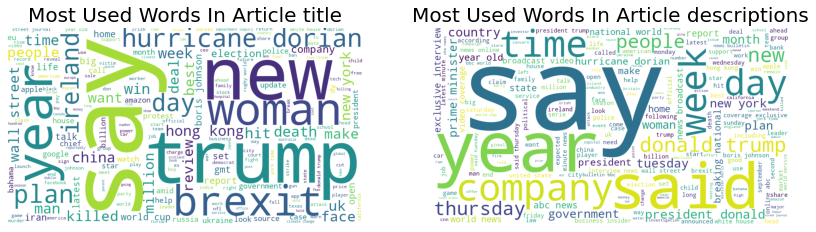

In [191]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[14,14])
wc1 = WordCloud(width=900,height=500,stopwords=STOPWORDS, background_color = 'white').generate(' '.join(df.cleaned_title))
wc2 = WordCloud(width=900,height=500,stopwords=STOPWORDS, background_color = 'white').generate(' '.join(df.cleaned_description))
ax1.imshow(wc1)
ax2.imshow(wc2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title("Most Used Words In Article title",fontsize=20)
ax2.set_title("Most Used Words In Article descriptions",fontsize=20)
plt.show()

### Sentiment

In [141]:
from textblob import TextBlob
# function to calculate subjectivity
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity
    # function to calculate polarity
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

# function to analyze the reviews
def analysis_sent(score):
    if score >= 0.5:
        return 'Positive'
    elif score <= -0.5:
        return 'Negative'
    else:
        return 'Neutral'

def analysis_subj(score):
    if score >= 0.5:
        return 'Subjective'
    else:
        return 'Objective'

In [142]:
df['subjectivityScore'] = df['cleaned_description'].apply(getSubjectivity)
df['polarityScore'] = df['cleaned_description'].apply(getPolarity)
df['polarity'] = df['cleaned_description'].apply(getPolarity).apply(analysis_sent)
df['subjectivity'] = df['cleaned_description'].apply(getSubjectivity).apply(analysis_subj)

In [143]:
positive_art=df[df['polarity']=='Positive']
neutral_art=df[df['polarity']=='Neutral']
negative_art=df[df['polarity']=='Negative']
subj=df[df['subjectivity']=='Subjective']
obj=df[df['subjectivity']=='Objective']

print("Total number of articles:", len(df))
count_neg=len(negative_art)
count_neu=len(neutral_art)
count_pos=len(positive_art)
count_subj=len(subj)
count_obj=len(obj)
print("Number of negative articles:", count_neg)
print("Number of neutral articles:", count_neu)
print("Number of positive articles:", count_pos)
print("Number of subjective articles:", count_subj)
print("Number of objective articles:", count_obj)

Total number of articles: 9653
Number of negative articles: 187
Number of neutral articles: 8958
Number of positive articles: 508
Number of subjective articles: 2726
Number of objective articles: 6927


In [31]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "histogram"}]]) #Making two plots

colors=['forestgreen','gold','indianred'] #Setting the color
labels = 'Positive', 'Neutral', 'Negative' #Setting the labels
values = [count_pos, count_neu, count_neg] #Stating the values for the pie plot

#Plotting the pie plot
fig.add_trace(go.Pie(labels=labels, values=values,name="",showlegend=False,
                     marker=dict(colors=colors,line=dict(color='#ffffff', width=6))),
     row=1, col=1)


#Plotting the histogram(negative)
fig.add_trace(go.Histogram(x=df.loc[df['polarity']=='Negative']['polarityScore'],
                           name="Negative",marker=dict(color="indianred"),xbins=dict(
        start=-1.0,
        end=1,
        size=0.1)),row=1, col=2)
#Plotting the histogram(positive)
fig.add_trace(go.Histogram(x=df.loc[df['polarity']=='Positive']['polarityScore'],
                           name="Positive",marker=dict(color="forestgreen"),xbins=dict(
        start=-1.0,
        end=1,
        size=0.1)),row=1, col=2)
#Plotting the histogram(neutral)
fig.add_trace(go.Histogram(x=df.loc[df['polarity']=='Neutral']['polarityScore'],
                           name="Neutral",marker=dict(color="gold"),xbins=dict(
        start=-1.0,
        end=1,
        size=0.1)),row=1, col=2)
fig.update_layout(hovermode="x unified",title_text='Sentiment distribution ',title_x=0.5) # title of plot)

config = {'displayModeBar': False}

fig.show(config=config)

In [32]:
grouped_count=df.groupby(['source_name','polarity']).count().reset_index()
grouped_count=grouped_count[['source_name','polarity','description']] 
grouped_count['description'] = grouped_count['description'] / grouped_count.groupby('source_name')['description'].transform('sum')*100
grouped_count#Plotting

fig = px.bar(grouped_count, x="source_name", y="description", color="polarity", title="Sentiment distribution per publisher",
             labels={'description':'%','source_name':'Publisher','polarity':''}, color_discrete_map={
        'Positive': 'forestgreen',
        'Neutral': 'gold','Negative': 'indianred'})
for data in fig.data:
    data["width"] = 0.6 #Change this value for bar widths

fig.update_layout(hovermode="x unified",title_x=0.5, legend=dict(
        x=1.0,
        y=0.5,        
    ))

config = {'displayModeBar': False}
fig.show(config=config)

In [33]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "histogram"}]]) #Making two plots

colors=['forestgreen','indianred'] #Setting the color
labels = 'Objective', 'Subjective' #Setting the labels
values = [count_obj, count_subj] #Stating the values for the pie plot

#Plotting the pie plot
fig.add_trace(go.Pie(labels=labels, values=values,name="",showlegend=False,
                     marker=dict(colors=colors,line=dict(color='#ffffff', width=6))),
     row=1, col=1)


#Plotting the histogram(Subjective)
fig.add_trace(go.Histogram(x=df.loc[df['subjectivity']=='Subjective']['subjectivityScore'],
                           name="Subjective",marker=dict(color="indianred"),xbins=dict(
        start=-1.0,
        end=1,
        size=0.1)),row=1, col=2)
#Plotting the histogram(Objective)
fig.add_trace(go.Histogram(x=df.loc[df['subjectivity']=='Objective']['subjectivityScore'],
                           name="Objective",marker=dict(color="forestgreen"),xbins=dict(
        start=-1.0,
        end=1,
        size=0.1)),row=1, col=2)
fig.update_layout(hovermode="x unified",title_text='Sentiment distribution ',title_x=0.5) # title of plot)

config = {'displayModeBar': False}

fig.show(config=config)

In [34]:
source_plot = df.groupby('source_name').subjectivityScore.mean().sort_values(ascending=False)

fig = px.bar(x=source_plot.index, y = source_plot.values, height=500, width=800)
fig.update_xaxes(title_text='Source name')
fig.update_yaxes(title_text='Mean subjectivity score')
fig.update_xaxes(type='category')
fig.show()

### LDA

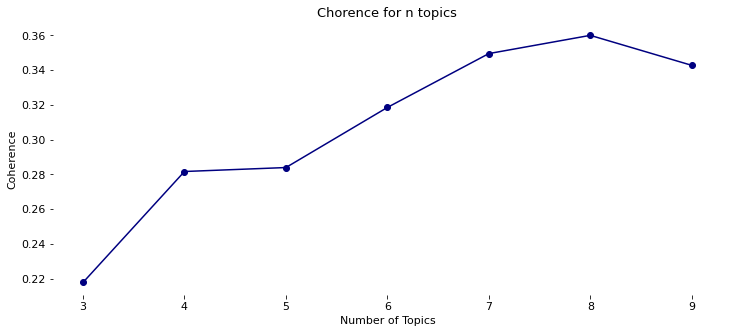

In [162]:
#Prepping model inputs
corpus = df['cleaned_description'].values.tolist()
tok_corp= [word_tokenize(sent) for sent in corpus]
lexi = corpora.Dictionary(tok_corp)
corpus = [lexi.doc2bow(d) for d in tok_corp]

plt.figure(figsize=(12, 5))

#Choose n parameter based on coherence measure
coherence_vals = []
for k in range(3,10):
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(corpus, num_topics=k,id2word = lexi, eval_every=None,passes=3,
               iterations=5,chunksize=100,random_state=123)

    cm = gensim.models.coherencemodel.CoherenceModel(\
         model=ldamodel, texts=tok_corp, dictionary=lexi, coherence='c_v')   

    coherence_vals.append((k,cm.get_coherence()))

n_topics = [x[0] for x in coherence_vals]
coherence = [x[1] for x in coherence_vals]

plt.plot(n_topics,coherence,color='navy')
plt.scatter(n_topics,coherence,color='navy')
plt.xlabel('Number of Topics',fontsize=11,color='black')
plt.ylabel('Coherence', fontsize=11,color='black')
plt.xticks(n_topics,fontsize=11,color='black')
plt.yticks(fontsize=11,color='black')
plt.title('Chorence for n topics',fontsize=13,color='black')
plt.box(False)

#plt.show()

In [164]:
#Running the LDA model with the optimal number of topics found above
n_sub_topics= 3+coherence.index(max(coherence))
lda = LdaModel(corpus=corpus, id2word=lexi, iterations=5,chunksize=100, passes=3,num_topics=n_sub_topics, 
          update_every=1, alpha='auto', random_state=123,eval_every=None)

In [165]:
#Finding the topics 
topic_data =  pyLDAvis.gensim_models.prepare(lda, corpus, lexi, mds = 'pcoa')
all_topics = {}
num_terms = 10 # Adjust number of words to represent each topic
lambd = 0.8# Adjust this accordingly based on tuning above
for i in range(1,n_sub_topics+1): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values
    topic_df = pd.DataFrame(all_topics).T
#Display keywords that represents each topic
topic_df

/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



,0,1,2,3,4,5,6,7,8,9
Topic 1,new,year,time,police,report,say,woman,old,officer,month
Topic 2,president,trump,said,house,donald,wednesday,deal,china,european,impeachment
Topic 3,company,million,stock,group,market,make,federal,chief,health,come
Topic 4,thursday,minister,prime,government,plan,brexit,say,man,johnson,british
Topic 5,state,people,ukraine,like,case,official,investigates,united,start,court
Topic 6,news,world,national,latest,video,service,online,biden,ireland,interview
Topic 7,business,story,insider,intelligence,medium,need,use,phone,want,morning
Topic 8,hour,help,correspondent,dead,northern,photo,disney,image,past,north


In [166]:
pyLDAvis.display(topic_data)

In [167]:
train_vecs = []
for i in range(len(df)):
    top_topics = lda.get_document_topics(corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(3+coherence.index(max(coherence)))]
    train_vecs.append(topic_vec)

In [176]:
topics = pd.DataFrame(train_vecs,columns = ['topic1','topic2','topic3','topic4','topic5','topic6','topic7','topic8'])
df = pd.concat([df, topics], axis=1)

### Correlation

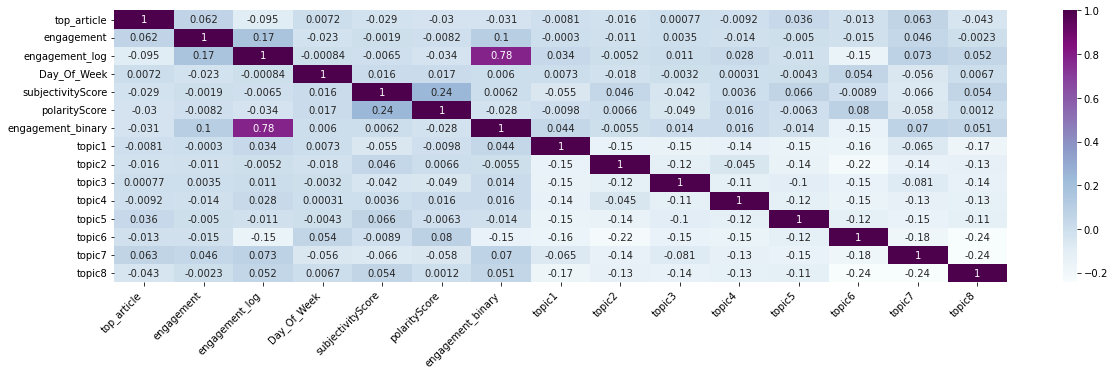

In [180]:
g = sns.heatmap(df.corr(), cmap="BuPu", annot=True)
g.set_xticklabels(g.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
plt.show()

### Split data

In [144]:
df['engagement_binary'] = (df['engagement_log'] > np.log(10)).astype(int)

In [145]:
from sklearn.model_selection import train_test_split
y = np.array(df[['engagement','engagement_log','engagement_binary']])
X = np.array(df[['source_name','title','cleaned_title','description','cleaned_description', 
                 'url_to_image','polarityScore','subjectivityScore']])
X_par, X_test, y_par, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_par, y_par, test_size=0.10, random_state=42)

In [146]:
X_train=pd.DataFrame(X_train, columns=['source_name','title','cleaned_title','description','cleaned_description','url_to_image',
                                       'polarityScore','subjectivityScore'])
X_val=pd.DataFrame(X_val, columns=['source_name','title','cleaned_title','description','cleaned_description','url_to_image',
                                   'polarityScore','subjectivityScore'])
X_test=pd.DataFrame(X_test, columns=['source_name','title','cleaned_title','description','cleaned_description','url_to_image',
                                     'polarityScore','subjectivityScore'])

y_train = pd.DataFrame(y_train, columns=['engagement','engagement_log','engagement_binary'])
y_val = pd.DataFrame(y_val, columns=['engagement','engagement_log','engagement_binary'])
y_test = pd.DataFrame(y_test, columns=['engagement','engagement_log','engagement_binary'])

In [147]:
import pickle

pickle.dump(X_train, open("X_train.p", "wb"))
pickle.dump(y_train, open("y_train.p", "wb"))
pickle.dump(X_val, open("X_val.p", "wb"))
pickle.dump(y_val, open("y_val.p", "wb"))
pickle.dump(X_test, open("X_test.p", "wb"))
pickle.dump(y_test, open("y_test.p", "wb"))

/opt/anaconda3/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
